In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.rcgp import GPRegressor, RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, LinearMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

0.6666558693945557
[ 81  88  92  97  98 100]


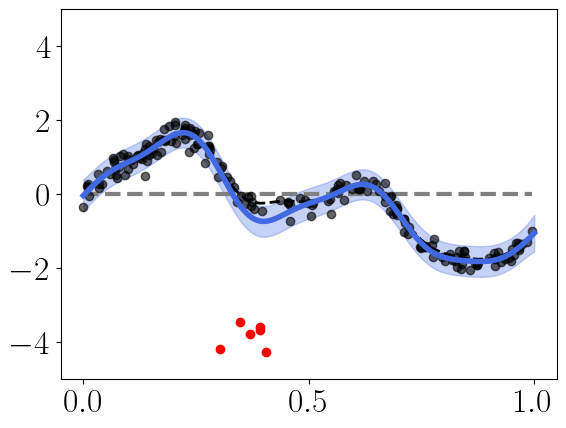

In [29]:
np.random.seed(13)

# Initialisation
epsilon = 0.03
n_points = 200
length_scale = 0.1
variance = 1
noise_variance = 0.04

# Simulation
mean_func = ConstantMean(constant=0)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=variance)

x_train = np.sort(np.random.uniform(0, 1.0, n_points)).reshape(-1, 1)
K_train = rbf_kernel(x_train, x_train)
f_train = np.random.multivariate_normal(mean_func(x_train).flatten(), K_train).reshape(-1, 1)
y_train = f_train + np.random.normal(0, np.sqrt(noise_variance), size=x_train.shape)

mean_y_train = np.mean(y_train)
print(mean_y_train)
y_train = y_train - mean_y_train

# Add outliers
outlier_range = np.where((x_train >= 0.3) & (x_train <= 0.44))[0]
outlier_indices = np.sort(np.random.choice(outlier_range, int(n_points * epsilon), replace=False))
outlier_values = np.random.normal(loc=-3.8, scale=0.5, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)
print(outlier_indices)


# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

prior_mean = ConstantMean(constant=0)
rcgp_w = RCGPRegressor(mean=prior_mean, length_scale=length_scale, rbf_variance=variance, noise=noise_variance, epsilon=epsilon)
rcgp_w.fit(x_train, y_train)

mu_w, var_w = rcgp_w.predict(x_test)
std_w = np.sqrt(var_w + rcgp_w.noise)

plt.plot(x_train, 0 * np.ones(len(x_train)), '--', color='grey', linewidth=3)
plt.plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
plt.plot(x_train, f_train - mean_y_train, '--', color='black', linewidth=2)
plt.plot(x_test, mu_w.ravel(), color="royalblue")
plt.fill_between(x_test.ravel(), mu_w.ravel() - 1.96 * std_w, mu_w.ravel() + 1.96 * std_w, alpha=0.3, color='royalblue')

# # Plot
# plt.figure(figsize=(8, 4))
# plt.plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
# plt.plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)  # darker grey, slightly transparent
# plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)               # red dots
# plt.plot(x_train, f_train, '--', color='black', linewidth=2)                              # thicker true function

plt.ylim(-5, 5)
plt.show()

Optimized length_scale: 0.0234, noise: 0.147966, rbf_variance: 1.5906
Optimized length_scale: 0.0766, noise: 0.137460, rbf_variance: 0.1240
loo_log: [-2.30924766e-02  2.62695515e-02 -2.15666646e-01 -4.05604652e-01
 -1.45648754e-01  2.59916937e-02 -2.79087759e-03 -2.09098749e-01
 -9.31912010e-04 -1.66265454e-02 -6.44100342e-02 -6.39761432e-01
  2.29509812e-02 -7.09742993e-02 -1.81306104e-01 -2.59183009e-02
 -1.96267368e-01 -1.59340352e-01  1.59444551e-02  2.12750891e-02
 -2.93957818e-01 -2.47812095e-01 -1.30366895e+00 -4.02354461e-01
 -4.07536172e-01 -5.77479371e-02 -3.45212161e-01 -3.33414978e-01
 -4.04352084e-01  5.02509604e-03 -9.10334581e+01]
weights: [0.49874043 0.97742279 0.44200721 0.99727384 0.99420674 0.99349726
 0.99021027 0.94517889 0.99852604 0.99710292 0.9927502  0.96324939
 0.98924839 0.99399108 0.99626508 0.99802886 0.967897   0.99950252]


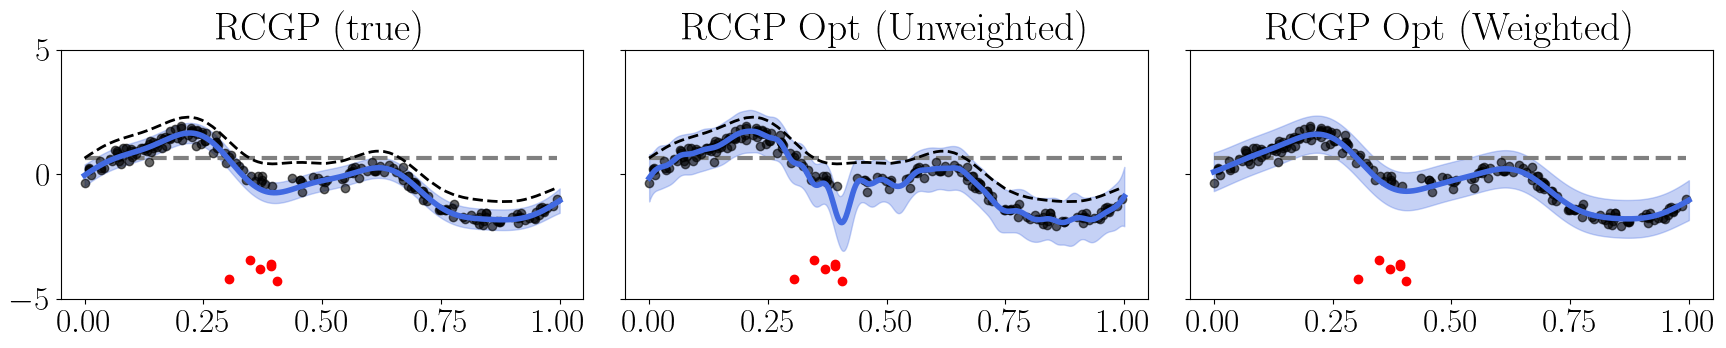

In [30]:
initial_length_scale = 0.1
initial_rbf_variance = 1
initial_noise = 0.04

# Create subplot figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# --- Plot 1: RCGP with weighted LOO-CV not optimized ---
rcgp_w = RCGPRegressor(mean=prior_mean, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise, epsilon=epsilon)
rcgp_w.fit(x_train, y_train)

mu_w, var_w = rcgp_w.predict(x_test)
std_w = np.sqrt(var_w + rcgp_w.noise)

axs[0].plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
axs[0].plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
axs[0].plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
axs[0].plot(x_train, f_train, '--', color='black', linewidth=2)
axs[0].plot(x_test, mu_w.ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu_w.ravel() - 1.96 * std_w, mu_w.ravel() + 1.96 * std_w, alpha=0.3, color='royalblue')
axs[0].set_title("RCGP (true)")

# --- Plot 2: RCGP with unweighted LOO-CV optimization ---
rcgp = RCGPRegressor(mean=prior_mean, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise, epsilon=epsilon)
rcgp.fit(x_train, y_train)
rcgp.optimize_loo_cv(weighted=False, print_opt_param=True, print_iter_param=False)

mu, var = rcgp.predict(x_test)
std = np.sqrt(var + rcgp.noise)

axs[1].plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
axs[1].plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
axs[1].plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
axs[1].plot(x_train, f_train, '--', color='black', linewidth=2)
axs[1].plot(x_test, mu.ravel(), color="royalblue")
axs[1].fill_between(x_test.ravel(), mu.ravel() - 1.96 * std, mu.ravel() + 1.96 * std, alpha=0.3, color='royalblue')
axs[1].set_title("RCGP Opt (Unweighted)")

# --- Plot 3: RCGP with weighted LOO-CV optimization ---
rcgp_w = RCGPRegressor(mean=prior_mean, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise, epsilon=epsilon)
rcgp_w.fit(x_train, y_train)
rcgp_w.optimize_loo_cv(weighted=True, print_opt_param=True, print_iter_param=False)

# print(rcgp_w.loo_cv(weighted=True, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise))
print('loo_log:', rcgp_w.predictive_log_prob.reshape(-1)[51:82])
print('weights:', rcgp_w.weight.reshape(-1)[98:116])

mu_w, var_w = rcgp_w.predict(x_test)
std_w = np.sqrt(var_w + rcgp_w.noise)

axs[2].plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
axs[2].plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
axs[2].plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
# axs[2].plot(x_train, f_train, '--', color='black', linewidth=2)
axs[2].plot(x_test, mu_w.ravel(), color="royalblue")
axs[2].fill_between(x_test.ravel(), mu_w.ravel() - 1.96 * std_w, mu_w.ravel() + 1.96 * std_w, alpha=0.3, color='royalblue')
axs[2].set_title("RCGP Opt (Weighted)")

# Common settings
for ax in axs:
    ax.set_ylim(-5, 5)

plt.tight_layout()
plt.show()
